<a href="https://colab.research.google.com/github/falcooon/DULoc/blob/main/beta/ESMFold_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**ESMFold_advanced**
for more details see: [Github](https://github.com/facebookresearch/esm/tree/main/esm), [Preprint](https://www.biorxiv.org/content/10.1101/2022.07.20.500902v1)

#### **Tips and Instructions**
- click the little ▶ play icon to the left of each cell below.

#### **Colab Limitations**
- On Tesla T4 (typical free colab GPU), max total length ~ 900



In [1]:
%%time
#@title install
#@markdown install ESMFold, OpenFold and download Params (~2min 30s)

import os, time
import torch
if not os.path.isfile("esmfold.model"):
  # download esmfold params
  os.system("apt-get install aria2 -qq")
  os.system("aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/esmfold.model &")

  # install libs
  print("installing libs...")
  os.system("pip install -q omegaconf pytorch_lightning biopython ml_collections einops py3Dmol modelcif")
  os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")

  print("installing openfold...")
  # install openfold
  os.system(f"pip install -q git+https://github.com/sokrypton/openfold.git")

  print("installing esmfold...")
  # install esmfold
  os.system(f"pip install -q git+https://github.com/sokrypton/esm.git@beta")

  # wait for Params to finish downloading...
  if not os.path.isfile("esmfold.model"):
    # backup source!
    os.system("aria2c -q -x 16 https://files.ipd.uw.edu/pub/esmfold/esmfold.model")
  else:
    while os.path.isfile("esmfold.model.aria2"):
      time.sleep(5)

if "model" not in dir():
  model_path = "esmfold.model"
  model = torch.load(model_path, weights_only=False)
  model.cuda().requires_grad_(False)

import os
import re
import hashlib
import numpy as np
import torch
from string import ascii_uppercase, ascii_lowercase
from jax.tree_util import tree_map
from scipy.special import softmax
from typing import Optional

def get_hash(x: str) -> str:
    """Generates a SHA1 hash for a given string."""
    return hashlib.sha1(x.encode()).hexdigest()

def parse_output(output: dict) -> dict:
    """
    Parses the raw model output dictionary to extract key metrics and structures.

    Args:
        output: The raw dictionary from model.infer().

    Returns:
        A dictionary containing pae, plddt, contacts, and xyz coordinates.
    """
    pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
    plddt = output["plddt"][0, :, 1]

    bins = np.append(0, np.linspace(2.3125, 21.6875, 63))
    sm_contacts = softmax(output["distogram_logits"], -1)[0]
    sm_contacts = sm_contacts[..., bins < 8].sum(-1)
    xyz = output["positions"][-1, 0, :, 1]
    mask = output["atom37_atom_exists"][0, :, 1] == 1

    o = {"pae": pae[mask, :][:, mask],
         "plddt": plddt[mask],
         "sm_contacts": sm_contacts[mask, :][:, mask],
         "xyz": xyz[mask]}

    if "contacts" in output["lm_output"]:
        lm_contacts = output["lm_output"]["contacts"].astype(float)[0]
        o["lm_contacts"] = lm_contacts[mask, :][:, mask]

    return o

# --- Main Prediction Function ---

def predict_esmfold(
    model: torch.nn.Module,
    sequence: str,
    jobname: str = "test",
    num_recycles: int = 3,
    get_LM_contacts: bool = False,
    copies: int = 1,
    chain_linker: int = 25,
    samples: Optional[int] = None,
    masking_rate: float = 0.15,
    stochastic_mode: str = "LM",
    save_dir: str = ".",
    verbose=False
) -> dict:
    """
    Runs ESMFold prediction for a given sequence and parameters.

    Args:
        model: The loaded ESMFold torch model.
        sequence: The amino acid sequence (e.g., "GWSTELEKH...").
        jobname: A name for the prediction job.
        num_recycles: Number of recycling iterations (0, 1, 2, 3, 6, 12).
        get_LM_contacts: Whether to return language model contacts.
        copies: Number of copies for homo-oligomeric predictions.
        chain_linker: Length of the 'X' linker for multimers.
        samples: Number of stochastic samples (None, 1, 4, 8, 16, 32, 64).
        masking_rate: Masking rate for stochastic LM sampling.
        stochastic_mode: Type of stochastic sampling ("LM", "LM_SM", "SM").
        save_dir: Directory to save PDB files and results.

    Returns:
        A dictionary containing:
        - "best_output": Raw output dictionary of the best model.
        - "best_pdb_str": PDB string of the best model (highest ptm).
        - "best_ptm": The ptm score of the best model.
        - "trajectory": A list of parsed outputs for each sample.
        - "prediction_dir": The specific directory where results were saved.
    """

    # --- Input Processing ---
    jobname = re.sub(r'\W+', '', jobname)[:50]

    # Clean sequence
    sequence = re.sub("[^A-Z:]", "", sequence.replace("/", ":").upper())
    sequence = re.sub(":+", ":", sequence)
    sequence = re.sub("^[:]+", "", sequence)
    sequence = re.sub("[:]+$", "", sequence)

    if copies <= 0:
        copies = 1
    sequence = ":".join([sequence] * copies)

    seqs = sequence.split(":")
    lengths = [len(s) for s in seqs]
    length = sum(lengths)
    if verbose:
      print(f"Running prediction for job '{jobname}' with length {length}")

    ID = jobname + "_" + get_hash(sequence)[:5]
    prediction_dir = os.path.join(save_dir, ID)
    os.makedirs(prediction_dir, exist_ok=True)

    # --- Model Configuration ---
    # Optimized for Tesla T4
    if length > 700:
        model.trunk.set_chunk_size(64)
    else:
        model.trunk.set_chunk_size(128)

    if not next(model.parameters()).is_cuda:
        print("Warning: Model is not on CUDA. Moving to CUDA.")
        model.cuda()
    model.requires_grad_(False)

    # --- Prediction Loop ---
    best_pdb_str = None
    best_ptm = 0
    best_output = None
    traj = []

    num_samples = 1 if samples is None else samples

    for seed in range(num_samples):
        torch.cuda.empty_cache()

        current_seed_str = "default"
        mask_rate = 0.0
        model.train(False) # Set to eval mode by default

        if samples is not None:
            torch.manual_seed(seed)
            current_seed_str = f"seed{seed}"
            mask_rate = masking_rate if "LM" in stochastic_mode else 0.0
            model.train("SM" in stochastic_mode) # Set to train mode for dropout

        if verbose:
          print(f"Running sample {seed + 1}/{num_samples} (seed: {current_seed_str})...")

        output = model.infer(
            sequence,
            num_recycles=num_recycles,
            chain_linker="X" * chain_linker,
            residue_index_offset=512,
            mask_rate=mask_rate,
            return_contacts=get_LM_contacts
        )

        pdb_str = model.output_to_pdb(output)[0]
        output = tree_map(lambda x: x.cpu().numpy(), output)
        ptm = output["ptm"][0]
        plddt = output["plddt"][0, :, 1].mean()
        traj.append(parse_output(output))

        if verbose:
          print(f'Sample {seed} ptm: {ptm:.3f} plddt: {plddt:.1f}')

        if ptm > best_ptm:
            best_pdb_str = pdb_str
            best_ptm = ptm
            best_output = output

        # --- Save PDB File ---
        if samples is None:
            pdb_filename = f"ptm{ptm:.3f}_r{num_recycles}_{current_seed_str}.pdb"
        else:
            pdb_filename = (
                f"ptm{ptm:.3f}_r{num_recycles}_{current_seed_str}_"
                f"{stochastic_mode}_m{masking_rate:.2f}.pdb"
            )

        pdb_path = os.path.join(prediction_dir, pdb_filename)
        with open(pdb_path, "w") as f:
            f.write(pdb_str)
        if verbose:
          print(f"Saved PDB to {pdb_path}")

    if verbose:
      print(f"Prediction complete. Best ptm: {best_ptm:.3f}")

    return {
        "output": best_output,
        "pdb_str": best_pdb_str,
        "ptm": best_ptm,
        "traj": traj,
        "dir": prediction_dir,
        "lengths":lengths
    }


installing libs...
installing openfold...
installing esmfold...
CPU times: user 6.2 s, sys: 7.42 s, total: 13.6 s
Wall time: 3min 54s


In [13]:
#@title ##run **ESMFold**
jobname = "test" #@param {type:"string"}
sequence = "GWSTELEKHREELKEFLKKEGITNVEIRIDNGRLEVRVEGGTERLKRFLEELRQKLEKKGYTVDIKIE" #@param {type:"string"}

#@markdown ---
#@markdown ###**Advanced Options**
num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
get_LM_contacts = False #@param {type:"boolean"}

#@markdown **multimer options (experimental)**
#@markdown - use "/" to specify chainbreaks, (eg. sequence="AAA/AAA")
#@markdown - for homo-oligomeric predictions, set copies > 1

copies = 1 #@param {type:"integer"}
chain_linker = 25 #@param {type:"number"}

#@markdown **sampling options (experimental)**
#@markdown - Samples are generated via random masking (defined by `masking_rate`)
#@markdown of input sequence (stochastic_mode="LM") and/or via dropout within structure module (stochastic_mode="SM").
samples = None #@param ["None", "1", "4", "8", "16", "32", "64"] {type:"raw"}
masking_rate = 0.15 #@param {type:"number"}
stochastic_mode = "LM" #@param ["LM", "LM_SM", "SM"]

o = predict_esmfold(
      model=model,
      sequence=sequence,
      jobname=jobname,
      num_recycles=num_recycles,
      get_LM_contacts=get_LM_contacts,
      copies=copies,
      chain_linker=chain_linker,
      samples=samples,
      masking_rate=masking_rate,
      stochastic_mode=stochastic_mode)

TypeError: predict_esmfold() got an unexpected keyword argument 'model'

In [3]:
#@title display (optional) {run: "auto"}
#@markdown Note: If samples selected, the model with max pTM is displayed.
import py3Dmol


pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence" #@param ["confidence", "rainbow", "chain"]
if color == "confidence": color = "pLDDT"
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}
show_pdb(o["pdb_str"], color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=o["lengths"]).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

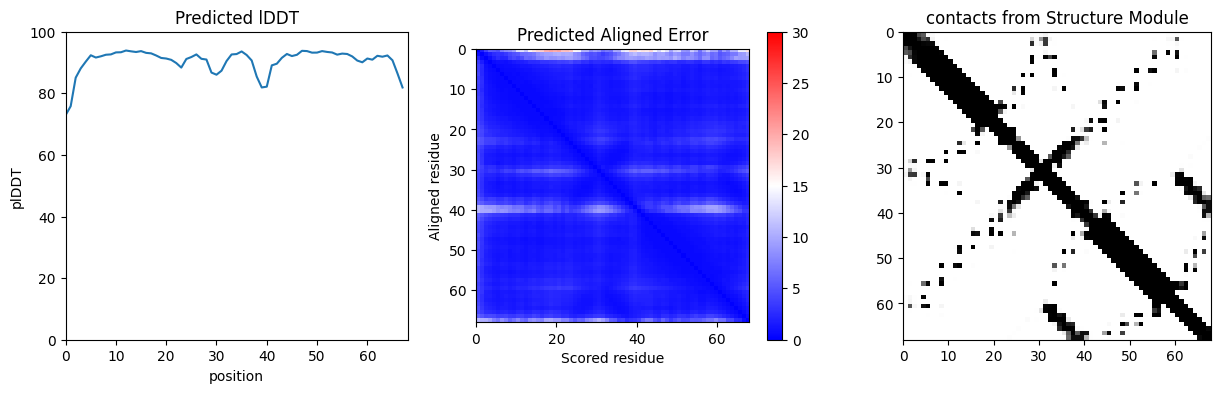

In [4]:
#@title plot confidence (optional)
#@markdown Note: If samples selected, the model with max pTM is displayed.
dpi = 100 #@param {type:"integer"}

import matplotlib.pyplot as plt
def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(output, Ls=None, dpi=100):
  O = parse_output(output)
  if "lm_contacts" in O:
    plt.figure(figsize=(20,4), dpi=dpi)
    plt.subplot(1,4,1)
  else:
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.subplot(1,3,1)

  plt.title('Predicted lDDT')
  plt.plot(O["plddt"])
  if Ls is not None:
    L_prev = 0
    for L_i in Ls[:-1]:
      L = L_prev + L_i
      L_prev += L_i
      plt.plot([L,L],[0,100],color="black")
  plt.xlim(0,O["plddt"].shape[0])
  plt.ylim(0,100)
  plt.ylabel('plDDT')
  plt.xlabel('position')
  plt.subplot(1,4 if "lm_contacts" in O else 3,2)

  plt.title('Predicted Aligned Error')
  Ln = O["pae"].shape[0]
  plt.imshow(O["pae"],cmap="bwr",vmin=0,vmax=30,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  plt.colorbar()
  plt.xlabel('Scored residue')
  plt.ylabel('Aligned residue')

  if "lm_contacts" in O:
    plt.subplot(1,4,3)
    plt.title("contacts from LM")
    plt.imshow(O["lm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
    if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
    plt.subplot(1,4,4)
  else:
    plt.subplot(1,3,3)
  plt.title("contacts from Structure Module")
  plt.imshow(O["sm_contacts"],cmap="Greys",vmin=0,vmax=1,extent=(0, Ln, Ln, 0))
  if Ls is not None and len(Ls) > 1: plot_ticks(Ls)
  return plt

plot_confidence(o["output"], Ls=o["lengths"], dpi=dpi)
plt.show()

In [ ]:
#@title download predictions
from google.colab import files
os.system(f"zip {o['dir']}.zip {o['dir']}/*")
files.download(f"{o['dir']}.zip")

In [5]:
#@title animate outputs (optional)
#@markdown if more than one sample generated
import os
if not os.path.isdir("colabfold"):
  os.system("git clone https://github.com/sokrypton/ColabFold.git")
import ColabFold.beta.colabfold as cf

dpi =  100#@param {type:"integer"}
color_by_plddt = True #@param {type:"boolean"}
use_pca = True
cycle = True

import matplotlib
from matplotlib import animation
from IPython.display import HTML
from sklearn.decomposition import PCA

def mk_animation(xyz, labels, plddt, ref=0, Ls=None, line_w=2.0, dpi=100,color_by_plddt=False):

  def ca_align_to_last(positions, ref):
    def align(P, Q):
      if Ls is None or len(Ls) == 1:
        P_,Q_ = P,Q
      else:
        # align relative to first chain
        P_,Q_ = P[:Ls[0]],Q[:Ls[0]]
      p = P_ - P_.mean(0,keepdims=True)
      q = Q_ - Q_.mean(0,keepdims=True)
      return ((P - P_.mean(0,keepdims=True)) @ cf.kabsch(p,q)) + Q_.mean(0,keepdims=True)

    pos = positions[ref] - positions[ref].mean(0,keepdims=True)
    best_2D_view = pos @ cf.kabsch(pos,pos,return_v=True)

    new_positions = []
    for i in range(len(positions)):
      new_positions.append(align(positions[i],best_2D_view))
    return np.asarray(new_positions)

  # align to reference
  pos = ca_align_to_last(xyz, ref)

  fig, (ax1) = plt.subplots(1)
  fig.set_figwidth(5)
  fig.set_figheight(5)
  fig.set_dpi(dpi)

  xy_min = pos[...,:2].min() - 1
  xy_max = pos[...,:2].max() + 1

  for ax in [ax1]:
    ax.set_xlim(xy_min, xy_max)
    ax.set_ylim(xy_min, xy_max)
    ax.axis(False)

  ims=[]
  for l,pos_,plddt_ in zip(labels,pos,plddt):
    if color_by_plddt:
      img = cf.plot_pseudo_3D(pos_, c=plddt_, cmin=50, cmax=90, line_w=line_w, ax=ax1)
    elif Ls is None or len(Ls) == 1:
      img = cf.plot_pseudo_3D(pos_, ax=ax1, line_w=line_w)
    else:
      c = np.concatenate([[n]*L for n,L in enumerate(Ls)])
      img = cf.plot_pseudo_3D(pos_, c=c, cmap=cf.pymol_cmap, cmin=0, cmax=39, line_w=line_w, ax=ax1)
    ims.append([cf.add_text(f"{l}", ax1),img])

  ani = animation.ArtistAnimation(fig, ims, blit=True, interval=120)
  plt.close()
  return ani.to_html5_video()

labels = np.array([f"seed:{x}" for x in range(len(o["traj"]))])
pos = np.array([x["xyz"] for x in o["traj"]])
plddt = np.array([x["plddt"] for x in o["traj"]])
if use_pca and pos.shape[0] > 1:
  pos_ca = pos
  if o["lengths"] is not None and len(o["lengths"]) > 1:
    pos_ca = pos_ca[:,:o["lengths"][0]]
  i,j = np.triu_indices(pos_ca.shape[1],k=1)
  pos_ca_dm = np.sqrt(np.square(pos_ca[:,None,:,:] - pos_ca[:,:,None]).sum(-1))[:,i,j]
  pc = PCA(1).fit_transform(pos_ca_dm)[:,0].argsort()
  if cycle:
    pc = np.append(pc,pc[1:-1][::-1])
  pos = pos[pc]
  labels = labels[pc]
  plddt = plddt[pc]
HTML(mk_animation(pos, labels, plddt, Ls=o["lengths"], dpi=dpi, color_by_plddt=color_by_plddt))

In [10]:
#@title ##run **ESMFold Folder**
def predict_esmfold(jobname,sequence):
  #@markdown ---
  #@markdown ###**Advanced Options**
  num_recycles = 3 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
  get_LM_contacts = False #@param {type:"boolean"}

  #@markdown **multimer options (experimental)**
  #@markdown - use "/" to specify chainbreaks, (eg. sequence="AAA/AAA")
  #@markdown - for homo-oligomeric predictions, set copies > 1

  copies = 1 #@param {type:"integer"}
  chain_linker = 25 #@param {type:"number"}

  #@markdown **sampling options (experimental)**
  #@markdown - Samples are generated via random masking (defined by `masking_rate`)
  #@markdown of input sequence (stochastic_mode="LM") and/or via dropout within structure module (stochastic_mode="SM").
  samples = None #@param ["None", "1", "4", "8", "16", "32", "64"] {type:"raw"}
  masking_rate = 0.15 #@param {type:"number"}
  stochastic_mode = "LM" #@param ["LM", "LM_SM", "SM"]

  o = predict_esmfold(
        model=model,
        sequence=sequence,
        jobname=jobname,
        num_recycles=num_recycles,
        get_LM_contacts=get_LM_contacts,
        copies=copies,
        chain_linker=chain_linker,
        samples=samples,
        masking_rate=masking_rate,
        stochastic_mode=stochastic_mode)
  return o

In [11]:
jobname = "test" #@param {type:"string"}
sequence = "GWSTELEKHREELKEFLKKEGITNVEIRIDNGRLEVRVEGGTERLKRFLEELRQKLEKKGYTVDIKIE" #@param {type:"string"}
o = predict_esmfold(
      model=model,
      sequence=sequence,
      jobname=jobname,
      num_recycles=num_recycles,
      get_LM_contacts=get_LM_contacts,
      copies=copies,
      chain_linker=chain_linker,
      samples=samples,
      masking_rate=masking_rate,
      stochastic_mode=stochastic_mode)

TypeError: predict_esmfold() got an unexpected keyword argument 'model'